[View in Colaboratory](https://colab.research.google.com/github/guitar79/OA-2018/blob/master/04_4_Identify_sunspot_using_SDO_iamge.ipynb)

**SDO data analysis**

* 이 자료는 [SDO](https://sdo.gsfc.nasa.gov/)의 HMII 자료를 이용하여 태양의 흑점을 찾아내는 교수학습자료이다.

* 이 자료는 아래 자료를 참고하여, python3 환경에서 돌아가도록 수정하여 작성하였다. 

* https://github.com/seungwonpark/SunSpotTracker

* python이 처음이라면 [Python Basic](https://colab.research.google.com/drive/1PCOoDIKypPVX9KTItMOht1cl96cPmeR_?authuser=1#scrollTo=3g6o04iLM0AF), [Python packages](https://colab.research.google.com/drive/1-1wx2VPEyNe11bmgpSpwdQgrJASCAqdH?authuser=1)를 먼저 학습하기를 권한다.

* 경기과학고등학교 관측천문학 강좌를 위해 만들었으며 라이센스는 다음을 따른다.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="크리에이티브 커먼즈 라이선스" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />이 저작물은 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">크리에이티브 커먼즈 저작자표시-비영리-동일조건변경허락 4.0 국제 라이선스</a>에 따라 이용할 수 있음.

#Introductons

먼저 태양관측위성 [SOHO](https://sohowww.nascom.nasa.gov/data/realtime/realtime-update.html)와 [SDO](https://sdo.gsfc.nasa.gov/) 애 대해 학습해 본다.



# The sun data

SDO 사이트에서는 자료를 검색하여 다운로드 받을 수 있는 툴(https://sdo.gsfc.nasa.gov/data/aiahmi/)을 제공하고 있다.

SDO 자료가 저장되어 있는 주소(https://sdo.gsfc.nasa.gov/assets/img/browse/)에 접속하면 YYYY/MM/DD 형태의 폴더 안에 자료가 정리되어 있는 것을 볼 수 있다. 

이 곳에 저장된 여러 태양 자료들 중에서 1024 pixel의 HMII 자료를 이용하여 흑점을 찾아보자. 

이 수업에 [20170228_231038_1024_MHII.jpg](https://sdo.gsfc.nasa.gov/assets/img/browse/2017/02/28/20170228_231038_3072_HMII.jpg)를 이용하였다.

# Processing

imread 함수로 이미지의 픽셀 값들을 배열로 불러들여 사진의 dimension을 알아보자.

In [1]:
# Based on Python 3.5.2 | Anaconda 4.1.1
# Print software information
# print('Source : https://github.com/seungwonpark/SunSpotTracker')

#ModuleNotFoundError: No module named 'cv2' 
#conda install -c https://conda.binstar.org/menpo opencv

import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import Circle

fname = '20170228_231038_1024_HMII.jpg'

# variables for processing
sun_im = plt.imread(fname)
im_width, im_height = np.shape(sun_im)
im_center_x, im_center_y = im_width/2, im_height/2
print('sun image dimension :', np.shape(sun_im))

sun image dimension : (1024, 1024)


sun_im 에 픽셀 값들이 배열 (1024,1024) 형태의 배열로 들어 있다. 이를 화면에 디스플레이 해 보자.

********************************************************************************
display sun image


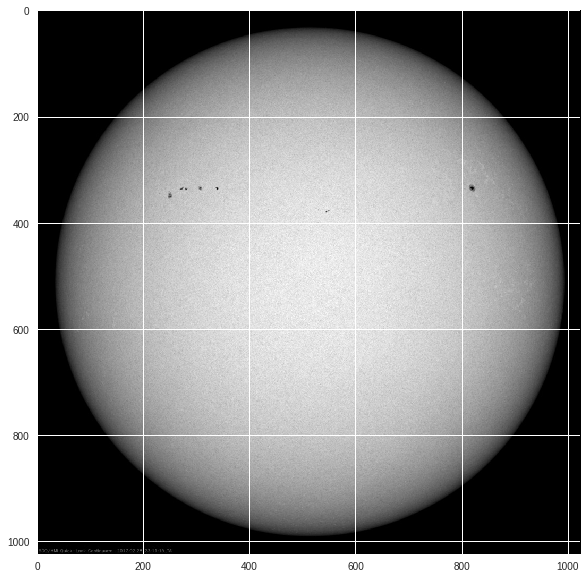

In [2]:
# Set figure width to 10 and height to 10
plt.rcParams["figure.figsize"] = [10,10]

# display sun image
print ('*'*80)
print ('display sun image')
plt.imshow(sun_im, cmap = 'gray', interpolation = 'None')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

태양 테두리의 원의 방정식을 찾아보자. 이 과정은 경우에 따라 실패할 수도 있으며, 실패할 경우 [512, 512, 480] 정도로 사용해도 될 것이다.

In [3]:
# detect circles of sun from the image
print ('*'*80)
print('detecting circle of sun')
sun_circle = cv2.HoughCircles(sun_im, cv2.HOUGH_GRADIENT, 2, 200)
# convert the (x, y, r) coordinates and radius of the circles to integers
sun_circle = np.round(sun_circle[0,0,:]).astype(int)
print('circle of sun', sun_circle )

********************************************************************************
detecting circle of sun
circle of sun [515 511 480]


태양 이미지 위에 원을 그려보자.

********************************************************************************
Drawing circle on the sun image


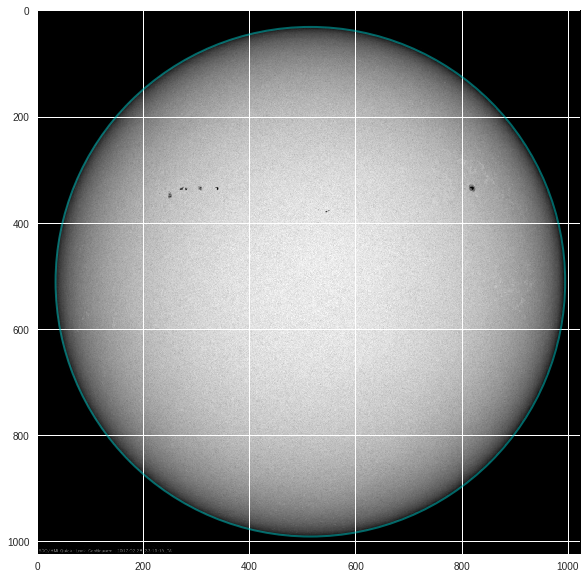

In [4]:
# Drawing circle on the sun image
print ('*'*80)
print ('Drawing circle on the sun image')
#fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots()
plt.imshow(sun_im, cmap = 'gray', interpolation = 'None')
circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2], facecolor='none',
            edgecolor=(0, 0.8, 0.8), linewidth=2, alpha=0.5)
ax.add_patch(circle)    
plt.show()  


태양의 사진을 보면 흑점도 검은색이고, 배경도 검은색이다. 
* 검은색 배경은 흑점 판단에 방해가 되므로 배경이 되는 부분을 삭제하기위한 making array를 생성하고자 한다. 
* 주연감광으로 인해 어두워진 가장자리 일부는 흑점 판단에 어려움을 초래하므로 그 경계부분을 잘 결정해야 한다. 여기에서 boundary_width는 위에서 구한 원의 방정식에서 반지름을 조금 줄여 주연감광 부분을 없애기 위한 변수이다.

이러한 처리를 하기 위해 먼저 태양사진 원본으로 부터 sun_im_output 이라는 변수로 복사를 한 후에 작업을 하였다.


In [5]:
# Remove black background
# copy image for processing
sun_im_output = sun_im.copy()
# make masking array for background
X, Y = np.ogrid[0:im_width, 0:im_height]
boundary_width = 60 # variable for removing limb darkening area
outer = (X - sun_circle[0]) ** 2 + (Y - sun_circle[1]) ** 2 > (sun_circle[2] - boundary_width) ** 2 
inner = (X - sun_circle[0]) ** 2 + (Y - sun_circle[1]) ** 2 < (sun_circle[2] - boundary_width) ** 2 

print (type(outer), type(inner))
print (np.shape(outer), np.shape(inner))
print (outer)
print (inner)

sun_im_output[outer] = 255

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1024, 1024) (1024, 1024)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


우리가 흑점을 판단할 부분만 남긴 사진을 보면 다음과 같다. 

********************************************************************************
after removing black pixels
boundary width : 60


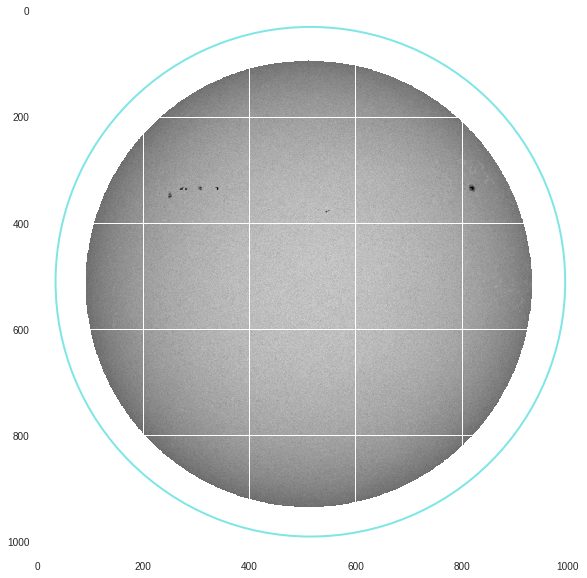

In [6]:
print ('*'*80)
print ('after removing black pixels')
print ('boundary width :', boundary_width)
fig, ax = plt.subplots()
plt.imshow(sun_im_output, cmap = 'gray', interpolation = 'None')
circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2], facecolor='none',
            edgecolor=(0, 0.8, 0.8), linewidth=2, alpha=0.5)
ax.add_patch(circle)    
plt.show()

흑점이라고 생각되는 픽셀 만을 골라보자. 흑점 판단 기준을 bright_criterion 변수를 사용하여 70보다 어두운 부분을 흑점인 픽셀로 분류해 보았다. 

코드에서 흑점이 아닌 픽셀들은 모두 흰색으로 바꾸었고, 흑점이라고 예상되는 픽셀정보를 check_pixel 변수에 list 형태로 저장하는 코드이다. 

In [0]:
# Obtaining pixels expected to be sunspots
bright_criterion = 70 # variable for sunspot criterion
sunspot_mask  = np.zeros((im_width, im_height)).astype(bool)
check_pixel = [] # x, y, intensity
for i in range(0, im_width):
    for j in range(0, im_height):
        if(sun_im_output[i,j] < bright_criterion):
            sunspot_mask[i,j] = 0
            check_pixel.append([j, i, sun_im_output[i,j]])
        else : 
            sunspot_mask[i,j] = 1
sun_im_output[sunspot_mask] = 255 #non-sunspot pixels will be white

골라진 픽셀들을 표출해 보자.

********************************************************************************
pixels expected to be sunspots
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


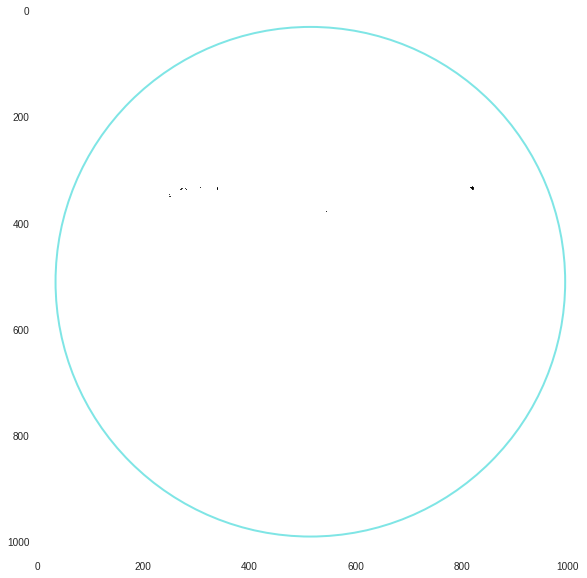

In [8]:
print ('*'*80)
print ('pixels expected to be sunspots')
print (sun_im_output)
fig, ax = plt.subplots()
plt.imshow(sun_im_output, cmap = 'gray', interpolation = 'None')
circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2], facecolor='none',
            edgecolor=(0, 0.8, 0.8), linewidth=2, alpha=0.5)
ax.add_patch(circle) 
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

 check_pixel 변수에 저장되어 있는 것들에 대해서 흑점인지 흑점인지 아닌지 다시한번 판단해 보고자 한다.
 
 판단해야 하는 number of pixels  갯수를 알려주고, 화면에 polt 해 보자.
 
이 부분은 현재까지 처리 과정에 오류가 없는지 확인할 수 있게 해 줄 것이다. 

number of pixels for  for checking if it is sunspot or not : 66
********************************************************************************
pixels for checking if it is sunspot or not


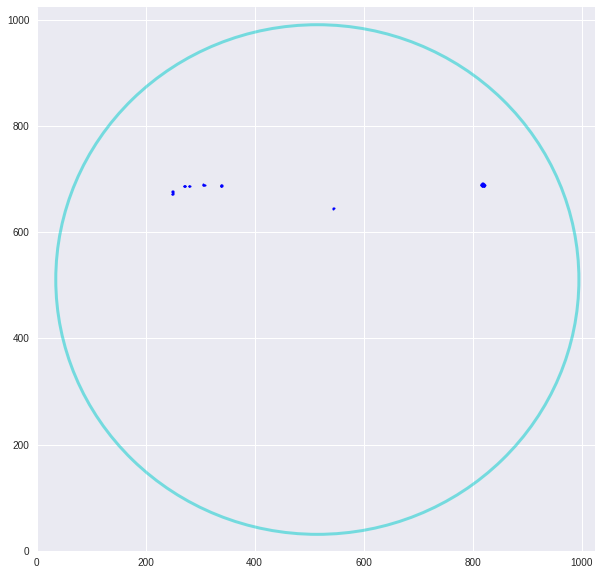

In [9]:
check_pixel = np.asarray(check_pixel)
print ('number of pixels for  for checking if it is sunspot or not :', len(check_pixel))
#print (check_pixel)
if len(check_pixel) == 0 : 
    print('There is no sunspot pixel in the image')
else :
    print ('*'*80)
    print ('pixels for checking if it is sunspot or not')
    fig,ax = plt.subplots()
    l = plt.plot(check_pixel[:,0], (im_height-check_pixel[:,1]), 'bo')
    plt.setp(l, markersize=2)
    circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2], facecolor='none',
                edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
    ax.add_patch(circle)
    #plt.setp(l, markerfacecolor='C0')
    plt.xlim((0, im_width))
    plt.ylim((0, im_height))
    #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

흑점의 x, y 좌표로 부터 위도와 경도를 구하기 위하여 앞에서 알아낸 원의 방정식을 이용하였다. 

또한 check_pixel 변수에 저장되어 있는 pixel들로 흑점을 판단하기 위해 [DFS algorithm](https://en.wikipedia.org/wiki/Depth-first_search)을 적용하는 함수이다.


In [0]:
# Calculation of latitude and longitude of sunspot on sun
def latitude(y):
    return math.asin( (sun_circle[1] - y) / sun_circle[2] )
def longitude(x,y):
    return math.asin( (x - sun_circle[0]) / (sun_circle[2] * math.cos(latitude(y))) )

#######################################################
#### DFS range. Need to determine this taxi radius.####
dx = [0,1,1,1,0,-1,-1,-1]
dy = [1,1,0,-1,-1,-1,0,1]
#######################################################
def dfs(x,y): # DFS(Depth First Search)
    global x_pixel_sum
    global y_pixel_sum
    global num_pixel
    image[x][y] = -1 # mark as already visited.
    x_pixel_sum += x
    y_pixel_sum += y
    
    num_pixel += 1
    for i in range(0,len(dx)):
        if(image[x+dx[i]][y+dy[i]] == 1):
            dfs(x+dx[i],y+dy[i])
#######################################################

check_pixel 변수에 저장되어 있는 pixel들이 2개 이상 인접해 있으면 흑점으로 판단하도록 DFS 알고리즘을 적용하였다.

In [11]:
# identify sunspot from check_pixel
pixel_num_criterion = 2
sunspot_data = [] #x_average, y_average, num_pixel
image = [[0 for a in range(im_width)] for b in range(im_height)] # make list for checking pixels
for i in check_pixel:
    x = i[0]
    y = i[1]
    image[x][y] = 1
for a in range(0,im_width):
    for b in range(0,im_height):
        if(image[a][b] == 1):
            x_pixel_sum = 0
            y_pixel_sum = 0
            num_pixel = 0
            print('DFS...', a, b)
            dfs(a,b)
            if num_pixel > pixel_num_criterion :
                x_average = x_pixel_sum / num_pixel
                y_average = y_pixel_sum / num_pixel
                latit = latitude(y_average)
                longi = longitude(x_average, y_average)
                latit = math.degrees(latit)
                longi = math.degrees(longi)
                #sunspot_data.append([longi, latit, num_pixel])
                sunspot_data.append([int(x_average), int(y_average), num_pixel])
print ('*'*80)
print ('number of sunspot : ', len(sunspot_data))
print ('sunspot data : ', sunspot_data) #x, y, num_pixel

DFS... 248 351
DFS... 249 347
DFS... 251 350
DFS... 270 337
DFS... 279 336
DFS... 306 333
DFS... 338 336
DFS... 544 379
DFS... 815 334
********************************************************************************
number of sunspot :  7
sunspot data :  [[249, 347, 4], [271, 336, 6], [280, 336, 4], [306, 334, 6], [339, 335, 8], [544, 379, 3], [818, 334, 31]]


원본 태양 이미지 위에 흑점의 좌표를 표현하여 끝내자.

********************************************************************************
draw sunspot coordinate


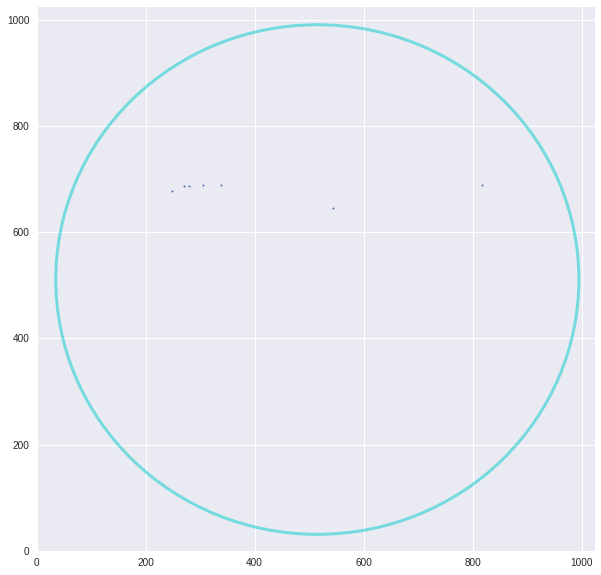

********************************************************************************
mark sunspot on the sun


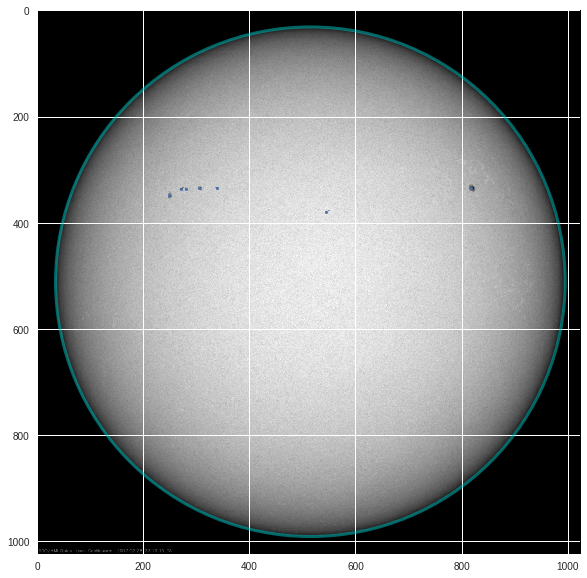

In [13]:
sunspot_data = np.asarray(sunspot_data)
if len(sunspot_data) == 0 : 
    print('There is no sunspot in the image')
else :
    print ('*'*80)
    print ('draw sunspot coordinate')
    fig,ax = plt.subplots()
    l = plt.plot(sunspot_data[:,0], (im_height-sunspot_data[:,1]), 'ro', markersize=2, markerfacecolor='C0')
    circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2], facecolor='none',
                edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
    ax.add_patch(circle)
    plt.xlim((0, im_width))
    plt.ylim((0, im_height))    
    #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

    print ('*'*80)
    print ('mark sunspot on the sun')
    # load the sun image
    fig,ax = plt.subplots()
    plt.imshow(sun_im, cmap = 'gray', interpolation = 'None')
    # draw a circle
    circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2], facecolor='none',
                edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
    ax.add_patch(circle)    
    # plot sunspot
    plt.plot(sunspot_data[:,0], (sunspot_data[:,1]), 'ro', markersize=3, markerfacecolor='C0')
    plt.show()